In [1]:
#Load the librarys
import pandas as pd #To work with dataset
import numpy as np #Math library
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score

# Task 1 - Creating Initial Model

In [2]:
column_names = ["Checking_Status", "Duration_Months", "Credit_History", "Purpose", "Credit_Amount",
                "Saving_Account", "Employment_Since", "Installment_Rate_Percentage", "Status_Sex", 
                "Debtors_Guarantors", "Residence_Since", "Property", "Age", "Installment_Plans", 
                "Housing", "Existing_credits", "Job", "People_Liable", "Telephone", "Foreign_Worker", "Loan"]

label_map = {i: col for i, col in enumerate(column_names)}

df = pd.read_csv('content/german.data', delimiter='\s', header=None)
df.columns = column_names
df.head()

/var/folders/tr/c8xx2ghs4vx8mgylq65_ffzm0000gn/T/ipykernel_88682/1541353363.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('content/german.data', delimiter='\s', header=None)


,Checking_Status,Duration_Months,Credit_History,Purpose,Credit_Amount,Saving_Account,Employment_Since,Installment_Rate_Percentage,Status_Sex,Debtors_Guarantors,...,Property,Age,Installment_Plans,Housing,Existing_credits,Job,People_Liable,Telephone,Foreign_Worker,Loan
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [3]:
df.nunique()

Checking_Status                  4
Duration_Months                 33
Credit_History                   5
Purpose                         10
Credit_Amount                  921
Saving_Account                   5
Employment_Since                 5
Installment_Rate_Percentage      4
Status_Sex                       4
Debtors_Guarantors               3
Residence_Since                  4
Property                         4
Age                             53
Installment_Plans                3
Housing                          3
Existing_credits                 4
Job                              4
People_Liable                    2
Telephone                        2
Foreign_Worker                   2
Loan                             2
dtype: int64

In [4]:
# 1 for Female and 0 for Male
gender = {"A91": 0, "A92": 1, "A93": 0, "A94": 0, "A95": 1}

# 1 for single and 0 for other
couple = {"A91": 0, "A92": 0, "A93": 1, "A94": 0, "A95": 1}

df["Gender"] = [gender[val] for val in df["Status_Sex"]]
df["Couple"] = [couple[val] for val in df["Status_Sex"]]
df = df.drop("Status_Sex", axis=1)

In [5]:
# We set age as 1 for age>=35 (adults with stable financial situation) and 0 for age<35 (budding young adults)
df['Age'] = [1 if age>=35 else 0 for age in df["Age"]]

In [6]:
# Setting loan = 1 if Good else 0 (for Bad)
df['Loan'] = [1 if loan==1 else 0 for loan in df["Loan"]]

In [7]:
def get_dummies(columns, label_map, df):
    print("Getting one hot encoding for:")
    for column in columns:
        print(column, label_map[column])
        dummies = pd.get_dummies(df[label_map[column]], prefix=label_map[column], drop_first=True)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(label_map[column], axis=1)
    return df

In [8]:
categorical = [0, 2, 3, 5, 6, 9, 11, 13, 14, 16, 18, 19]
df = get_dummies(categorical, label_map, df)

Getting one hot encoding for:
0 Checking_Status
2 Credit_History
3 Purpose
5 Saving_Account
6 Employment_Since
9 Debtors_Guarantors
11 Property
13 Installment_Plans
14 Housing
16 Job
18 Telephone
19 Foreign_Worker


<AxesSubplot:xlabel='Loan', ylabel='Count'>

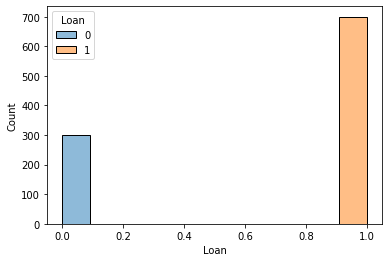

In [9]:
sns.histplot(df, x="Loan", hue="Loan")

In [10]:
# loan.value_counts()
df["Loan"].value_counts()

1    700
0    300
Name: Loan, dtype: int64

In [11]:
loan = df["Loan"]
df = df.drop("Loan", axis=1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df, loan, test_size=0.2, random_state=42)

In [13]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [14]:
y_pred = model.predict(X_test)
print("ROC AUC score:", roc_auc_score(y_test, y_pred))

ROC AUC score: 0.7335617261690107


# Task 2 - Measuring Fairness

#### Anti-classification Measurement

In [15]:
def binary_switch(X_test, col):
  map = {1:0, 0:1}

  X_test_copy = X_test.copy()
  X_test_copy[col] = [map[val] for val in X_test_copy[col]]

  return X_test_copy  

In [16]:
X_test_gender_switch = binary_switch(X_test, 'Gender')
X_test_age_switch = binary_switch(X_test, 'Age')

In [17]:
# 1 or close to 1 is similar (meaning fair) else not

def measure_anti_classification(model, X_test, X_test_switch, col):
  print("\nMeasuring anti-classification for", col, "-")
  y_pred = model.predict(X_test)
  y_pred_switch = model.predict(X_test_switch)
  print("Similarity score: ", round(cosine_similarity([y_pred], [y_pred_switch])[0][0], 4))

In [18]:
measure_anti_classification(model, X_test, X_test_gender_switch, "Gender")


Measuring anti-classification for Gender -
Similarity score:  1.0


In [19]:
measure_anti_classification(model, X_test, X_test_age_switch, "Age")


Measuring anti-classification for Age -
Similarity score:  0.9378


In [20]:
total = 0

print("For Age -")
for og, ch in zip(X_test["Age"], X_test_age_switch["Age"]):
  total += (og == ch)
print("Total rows in test: ", len(X_test))
print("Rows same in original and switched: ", total)

total = 0

print("\nFor Gender -")
for og, ch in zip(X_test["Gender"], X_test_gender_switch["Gender"]):
  total += (og == ch)
print("Total rows in test: ", len(X_test))
print("Rows same in original and switched: ", total)

For Age -
Total rows in test:  200
Rows same in original and switched:  0

For Gender -
Total rows in test:  200
Rows same in original and switched:  0


#### Group Fairness Measurement

In [21]:
print("Group Fairness for Gender-")

y_pred_gender_1 = model.predict(X_test[X_test["Gender"] == 1])
y_pred_gender_0 = model.predict(X_test[X_test["Gender"] == 0])
print("Percentage of Females predicted as good: ", round((sum(y_pred_gender_1)/len(y_pred_gender_1))*100, 2), "%")
print("Percentage of Males predicted as good: ", round((sum(y_pred_gender_0)/len(y_pred_gender_0))*100, 2), "%")

Group Fairness for Gender-
Percentage of Females predicted as good:  73.21 %
Percentage of Males predicted as good:  78.47 %


In [22]:
print("Group Fairness for Age-")

y_pred_age_1 = model.predict(X_test[X_test["Age"] == 1])
y_pred_age_0 = model.predict(X_test[X_test["Age"] == 0])
print("Percentage of people with age >=35 predicted as good: ", round((sum(y_pred_age_1)/len(y_pred_age_1))*100, 2), "%")
print("Percentage of people with age <35 predicted as good: ", round((sum(y_pred_age_0)/len(y_pred_age_0))*100, 2), "%")

Group Fairness for Age-
Percentage of people with age >=35 predicted as good:  84.27 %
Percentage of people with age <35 predicted as good:  71.17 %


#### Seperation Fairness Measurement

In [23]:
# Measuring Precision for the two classes in Age as cost of False positive is high
# Precision should be approximately same for both the classes
print("Seperation fairness mesurenment for Age-")

y_pred_age_1 = model.predict(X_test[X_test["Age"] == 1])
y_test_age_1 = [y for y, age in zip(y_test, X_test["Age"]) if age==1]

y_pred_age_0 = model.predict(X_test[X_test["Age"] == 0])
y_test_age_0 = [y for y, age in zip(y_test, X_test["Age"]) if age==0]

#FPR and FNR scores
from sklearn.metrics import confusion_matrix
cm_age_1 = confusion_matrix(y_test_age_1, y_pred_age_1)
cm_age_0=  confusion_matrix(y_test_age_0, y_pred_age_0)

#print(cm_age_1)
tn1, fp1, fn1, tp1 = cm_age_1.ravel()

#print(cm_age_0)
tn0, fp0, fn0, tp0 = cm_age_0.ravel()

print("FPR score for people with age>=35: ", round( fp1/(fp1 + tn1), 3))
print("FPR score for people with age<=35: ", round( fp0/(fp0 + tn0), 3))

print("\nFNR score for people with age>=35: ", round( fn1/(tp1 + fn1), 3))
print("FNR score for people with age<=35: ", round( fn0/(tp0 + fn0), 3))


Seperation fairness mesurenment for Age-
FPR score for people with age>=35:  0.615
FPR score for people with age<=35:  0.303

FNR score for people with age>=35:  0.063
FNR score for people with age<=35:  0.115


In [24]:
# Measuring Precision for the two classes in Age as cost of False positive is high
# Precision should be approximately same for both the classes
print("Seperation fairness mesurenment for Gender-")

y_pred_gender_1 = model.predict(X_test[X_test["Gender"] == 1])
y_test_gender_1 = [y for y, gender in zip(y_test, X_test["Gender"]) if gender==1]

y_pred_gender_0 = model.predict(X_test[X_test["Gender"] == 0])
y_test_gender_0 = [y for y, gender in zip(y_test, X_test["Gender"]) if gender==0]

cm_gender_1 = confusion_matrix(y_test_gender_1, y_pred_gender_1)
cm_gender_0=  confusion_matrix(y_test_gender_0, y_pred_gender_0)

#print(cm_age_1)
tn1, fp1, fn1, tp1 = cm_gender_1.ravel()

#print(cm_age_0)
tn0, fp0, fn0, tp0 = cm_gender_0.ravel()

print("FPR score for people with gender=1: ", round( fp1/(fp1 + tn1), 3))
print("FPR score for people with gender=0: ", round( fp0/(fp0 + tn0), 3))

print("\nFNR score for people with gender=1: ", round( fn1/(tp1 + fn1), 3))
print("FNR score for people with gender=0: ", round( fn0/(tp0 + fn0), 3))

Seperation fairness mesurenment for Gender-
FPR score for people with gender=1:  0.294
FPR score for people with gender=0:  0.5

FNR score for people with gender=1:  0.077
FNR score for people with gender=0:  0.098


# Task 3 - Improve Model Fairness

#### For anti-classification

In [25]:
# For anti-classification let's remove the protected variable while creating the model. We would be removing the variable Gender

X_train_fair = X_train.drop("Gender", axis=1)
X_test_fair = X_test.drop("Gender", axis=1)

model_fair = LogisticRegression(max_iter=1000)
model_fair.fit(X_train_fair, y_train)

y_pred_fair = model_fair.predict(X_test_fair)
print("ROC AUC score for new model:", roc_auc_score(y_test, y_pred_fair))

ROC AUC score for new model: 0.7300156268782306


In [26]:
X_test_gender_switch = binary_switch(X_test, 'Gender')
X_test_gender_switch_fair = X_test_gender_switch.drop("Gender", axis=1)

measure_anti_classification(model_fair, X_test_fair, X_test_gender_switch_fair, "Gender")


Measuring anti-classification for Gender -
Similarity score:  1.0


#### For Group Fairness

In [27]:
def get_best_threshold_group(model, X_text, col):
  divide_on = np.arange(0.2, 0.8, 0.01)
  min_score = 1
  best_threshold = 0.5

  y_pred_col_1_prob = model.predict_proba(X_test[X_test[col] == 1])
  y_pred_col_0_prob = model.predict_proba(X_test[X_test[col] == 0])

  for threshold in divide_on:

    y_pred_col_1 = [1 if val_0 <= threshold else 0 for val_0, _ in y_pred_col_1_prob] 
    y_pred_col_0 = [1 if val_0 <= threshold else 0 for val_0, _ in y_pred_col_0_prob]      

    difference = abs((np.sum(y_pred_col_1)/len(y_pred_col_1)) - (np.sum(y_pred_col_0)/len(y_pred_col_0)))
    if difference < min_score:
      min_score = difference
      best_threshold = threshold
      if min_score == 0:
        break
    
  return round(best_threshold, 2)


In [28]:
print("Group Fairness for Gender with new threshold-")

threshold = get_best_threshold_group(model, X_test, "Gender")
print("New threshold: ", threshold)

y_pred_gender_1_prob = model.predict_proba(X_test[X_test["Gender"] == 1])
y_pred_gender_0_prob = model.predict_proba(X_test[X_test["Gender"] == 0])

y_pred_gender_1 = [1 if prob < threshold else 0 for prob, _ in y_pred_gender_1_prob]
y_pred_gender_0 = [1 if prob < threshold else 0 for prob, _ in y_pred_gender_0_prob]

print("Percentage of Females predicted as good: ", round((np.sum(y_pred_gender_1)/len(y_pred_gender_1))*100, 2), "%")
print("Percentage of Males predicted as good: ", round((np.sum(y_pred_gender_0)/len(y_pred_gender_0))*100, 2), "%")

Group Fairness for Gender with new threshold-
New threshold:  0.6
Percentage of Females predicted as good:  82.14 %
Percentage of Males predicted as good:  81.94 %


#### For Seperation

In [29]:
def get_best_threshold_seperation(model, X_test, y_test, col):
  divide_on = np.arange(0.2, 0.8, 0.01)
  min_score = 1
  best_threshold = 0.5

  y_pred_col_1_prob = model.predict_proba(X_test[X_test[col] == 1])
  y_pred_col_0_prob = model.predict_proba(X_test[X_test[col] == 0])
  
  y_test_col_1 = [y for y, val in zip(y_test, X_test[col]) if val==1]
  y_test_col_0 = [y for y, val in zip(y_test, X_test[col]) if val==0]

  for threshold in divide_on:

    y_pred_col_1 = [1 if val_0 <= threshold else 0 for val_0, _ in y_pred_col_1_prob] 
    y_pred_col_0 = [1 if val_0 <= threshold else 0 for val_0, _ in y_pred_col_0_prob]


    cm_col_1 = confusion_matrix(y_test_col_1, y_pred_col_1)
    cm_col_0 = confusion_matrix(y_test_col_0, y_pred_col_0)
    difference = abs(precision_score(y_test_col_1, y_pred_col_1) - precision_score(y_test_col_0, y_pred_col_0))

    if difference < min_score:
      min_score = difference
      best_threshold = threshold
      if min_score == 0:
        break

  return round(best_threshold, 2)

In [30]:
# Measuring Precision for the two classes in Age as cost of False positive is high
# Precision should be approximately same for both the classes
print("Seperation fairness mesurenment for Gender with new threshold-")

threshold = get_best_threshold_seperation(model, X_test, y_test, "Gender")
print("New threshold: ", threshold)

y_pred_gender_1_prob = model.predict_proba(X_test[X_test["Gender"] == 1])
y_pred_gender_1 = [1 if prob < threshold else 0 for prob, _ in y_pred_gender_1_prob]
y_test_gender_1 = [y for y, gender in zip(y_test, X_test["Gender"]) if gender==1]

y_pred_gender_0_prob = model.predict_proba(X_test[X_test["Gender"] == 0])
y_pred_gender_0 = [1 if prob < threshold else 0 for prob, _ in y_pred_gender_0_prob]
y_test_gender_0 = [y for y, gender in zip(y_test, X_test["Gender"]) if gender==0]

print("Precision score for Females: ", round(precision_score(y_test_gender_1, y_pred_gender_1), 3))
print("Precision score for Males: ", round(precision_score(y_test_gender_0, y_pred_gender_0), 3))

Seperation fairness mesurenment for Gender with new threshold-
New threshold:  0.54
Precision score for Females:  0.818
Precision score for Males:  0.819


In [31]:
cm_gender_1 = confusion_matrix(y_test_gender_1, y_pred_gender_1)
cm_gender_0=  confusion_matrix(y_test_gender_0, y_pred_gender_0)

#print(cm_age_1)
tn1, fp1, fn1, tp1 = cm_gender_1.ravel()

#print(cm_age_0)
tn0, fp0, fn0, tp0 = cm_gender_0.ravel()

print("FPR score for people with gender=1: ", round( fp1/(fp1 + tn1), 3))
print("FPR score for people with gender=0: ", round( fp0/(fp0 + tn0), 3))

print("\nFNR score for people with gender=1: ", round( fn1/(tp1 + fn1), 3))
print("FNR score for people with gender=0: ", round( fn0/(tp0 + fn0), 3))

FPR score for people with gender=1:  0.471
FPR score for people with gender=0:  0.5

FNR score for people with gender=1:  0.077
FNR score for people with gender=0:  0.069
